여기에서는 첫번째로 프로젝트를 실험해본다.
해야 할 것은 03.09-12를 기본적으로 다시 따라가되, 몇가지 사항을 유념하는 것이다.
- 03.04-08에서 실시한 데이터 전처리가 필요하다.
- 03.09 (1)에서 했던 `y = np.log1p(y)`와 같은 처리도 필요하다.
- 03.10 (2)에서의 코드들은 일단은 필요하지 않다.
이곳에서 하는 것은 ensemble이다.
그런데 03.11 (3), 03.12 (4) 등에서 하는 것은 단일 모델에 대한 실험이다.
따라서 바로 적용하기는 너무 복잡하다.
여러 단일모델들에 대하여 최적의 hyperparameter 조합을 찾아보고, 그것으로 각각의 단일모델들을 최상의 모델들로 만든 뒤, 마지막 순간에 (정말 더 성능을 올리고 싶다면) 그 최상의 모델들을 ensemble해볼 수는 있겠다.
- 03.11 (3)의 코드들은 필요하다.
여기에서는 `LGBRegressor`를 가지고 hyperparameter tuning을 하고 있는데, 더 나아가서 다른 두 세 개의 모델들도 해볼 수 있다 :`XGBRegressor`, `RandomForestRegressor`, (`GradientBoostingRegressor`)
 또한, 두 개 종류의 hyperparameter들만 tuning하고 있는데, 더 나아가서 다른 hyperparameter들도 tuning할 수 있다.
- 03.12 (4)에서는 `my_GridSearch`함수와 `save_submission` 함수를 사용해, 재빠르게 여러 실험들을 하고, 그 결과를 파일로서 저장하게 된다.
이 과정들 자체는 kaggle에 올라가는 것이 아니다.
여러 번의 실험들을 통해 괜찮은 `RMSLE` 값을 조회하고, 그중 가장 괜찮은 결과들만을 kaggle에 업로드하여 최종점수를 확인하면 된다.

각각의 subsubsection (\#\#\#)의 최상단에는 해당 subsubsection에서 한 것에 대한 요약을 써놓겠다.

핵심이 되는 3.13.3.의 반복적인 수행을 위해서는 추가적인 버전의 ipynb 파일이 필요하다.
지금 이 파일은
- 3.13.1. 모듈 불러오기 및 파일 불러오기
- 3.13.2. 데이터 전처리
- 3.13.3. 모델 구성하기, `GridSearchCV`, 저장하기

로 구성하려고 한다.
추후 작업을 위한 전체적인 얼개를 설정하는 정도로만 이 파일을 쓸 것이다.

## 3.13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

### 3.13.1. 모듈 불러오기 및 파일 불러오기

- 필요한 모듈들을 전부 불러왔다.
- 필요한 파일을 불러왔다.
 파일을 불러오는 방식은 기본적으로 3.6. (3)의 방식을 따랐다.
 training set과 test set에 각각 해당하는 객체를 `data`와 `sub`에 할당했다.
 `shape`을 확인해보면 확인할 수 있지만, `data`에는 label에 해당하는 `price` 열이 있고 `sub`에는 없다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
print(data.shape)
print(sub.shape)
print(type(data))
print(type(sub))

(15035, 21)
(6468, 20)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### 3.13.2. 데이터 전처리

- 3.6. (3), 3.9. (1)의 전처리 과정을 통합했다.
 기본적으로는 3.6.(3)을 따라갔다.
 3.6. (3)에서 추가된 3.9. (1)의 사항은 `data` 열의 '연도+월'을 `int` 형태로 바꿔주었다는 점과 기존의 `y`를 로그변환한 것을 그냥 `y`에 덮어씌워서 할당했다는 점이다.
- 이전 subsubsection에서 `data`와 `price`객체를 각각 생성했었다.
이것들의 `shape`은 각각 (15035, 21), (6468, 20)이다.
- `data`의 `price`열만 따로 떼어 `y`에 할당했다.
 `price`열이 없어졌으니 `data`와 `sub`의 feature수가 같아졌다.
 `data`, `price`, `sub`의 shape은 각각 (15035, 20), (6468, 20), (15035,)이다.
- `data`와 `shape`을 합쳐 `data`라는 객체에 덮어씌워 할당한다.
다시 말해, 기존의 `data` 객체와 `sub` 객체는 사용하지 않을 것이다.
이렇게 하는 것은, (training set, test set에 걸쳐서 일관적으로) preprocess하기 위함이다.
- 첫번째 전처리로서, 결측치를 확인한다.
결측치는 없다.
결측치가 없다는 건 알고 있지만, 그래도 확인하기 위한 형식적인 절차이다.
- 두번째 전처리로서, `id` 열을 제거한다.
어차피 다음 subsection부터는 3.9. (1)을 따라갈 예정이어서 `sub_id`는 필요없을 것 같지만, 혹시 몰라서 지우지 않았다.
- 세번째 전처리로서, `data` 열의 문자열을 '연도+월'까지만 자른 뒤 `int`의 형태로 바꿔주었다.
- 네번째 전처리로서, log 변환을 해주었다.
feature(`data`)를 변환하는 것은 3.6. (3)을 따랐고, label(`y`)를 변환하는 것은 3.9. (1)을 따랐다.
- 다섯번째 전처리로서, train / test를 나누었다.`data` 객체를 `train`과 `test`로 나누었다.
최종적으로 얻은 세 개의 객체 `train`, `test`, `y`의 정보는 다음과 같다.

|객체명   |설명                     |shape      |dtype         |비고|
|:-:      |:-:                      |:-:        |:-:           ||
|`train`  |training dataset, feature|(15035, 19)|`pd.DataFrame`||
|`test`   |test dataset, feature    |(6468, 19) |`pd.DataFrame`||
|`y`      |training dataset, label  |(15035, )  |`pd.Series`   |log-scaled|
|(없음)   |test dataset, label      |           |              ||

In [5]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
print(data.shape)
print(sub.shape)
print(y.shape)
print(type(data))
print(type(sub))
print(type(y))

(15035, 20)
(6468, 20)
(15035,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [7]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)
print(train_len)
print(len(data))

15035
21503


<AxesSubplot:>

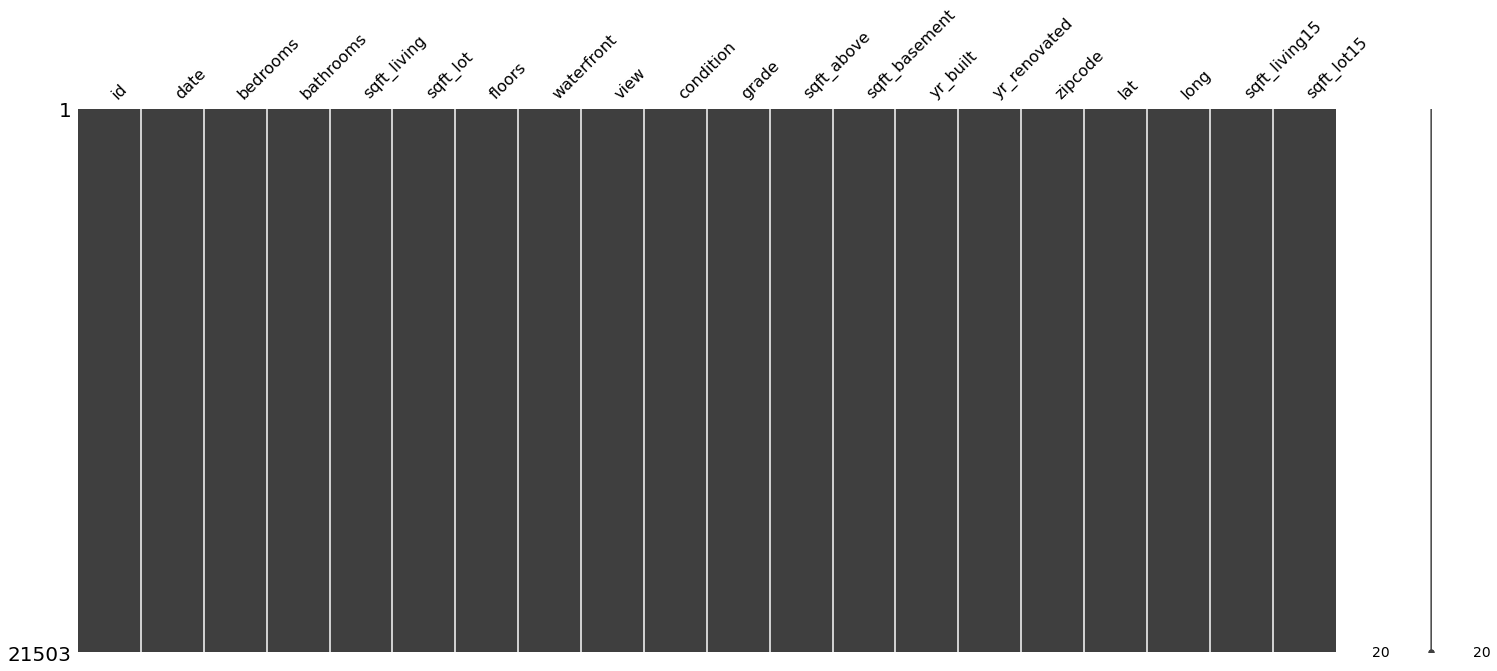

In [8]:
msno.matrix(data)

In [9]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [10]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


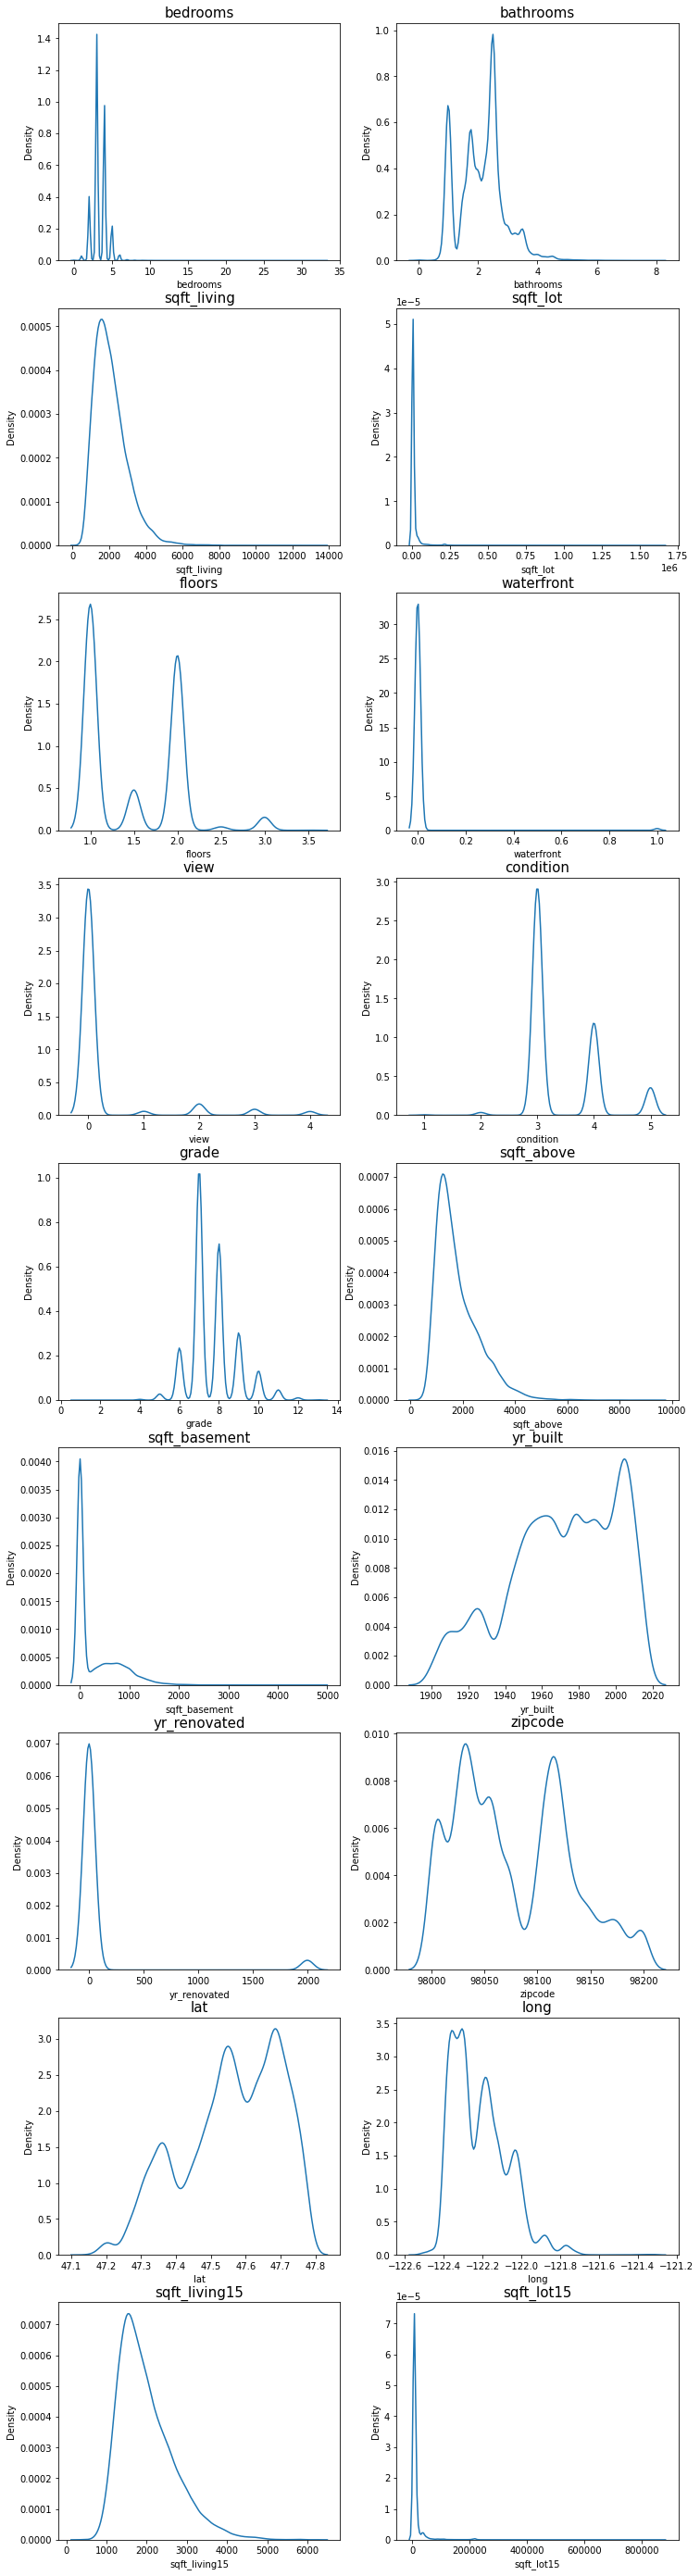

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [13]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

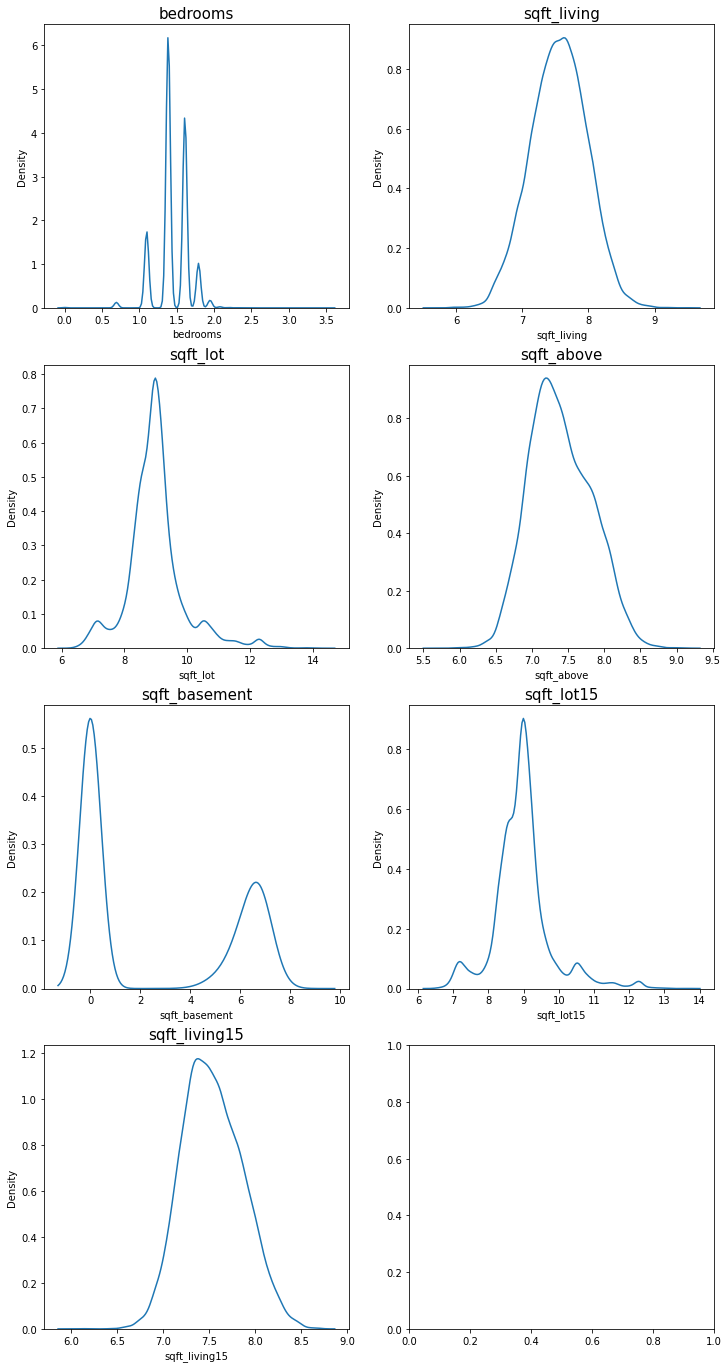

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [15]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]
y = np.log1p(y)

In [16]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975


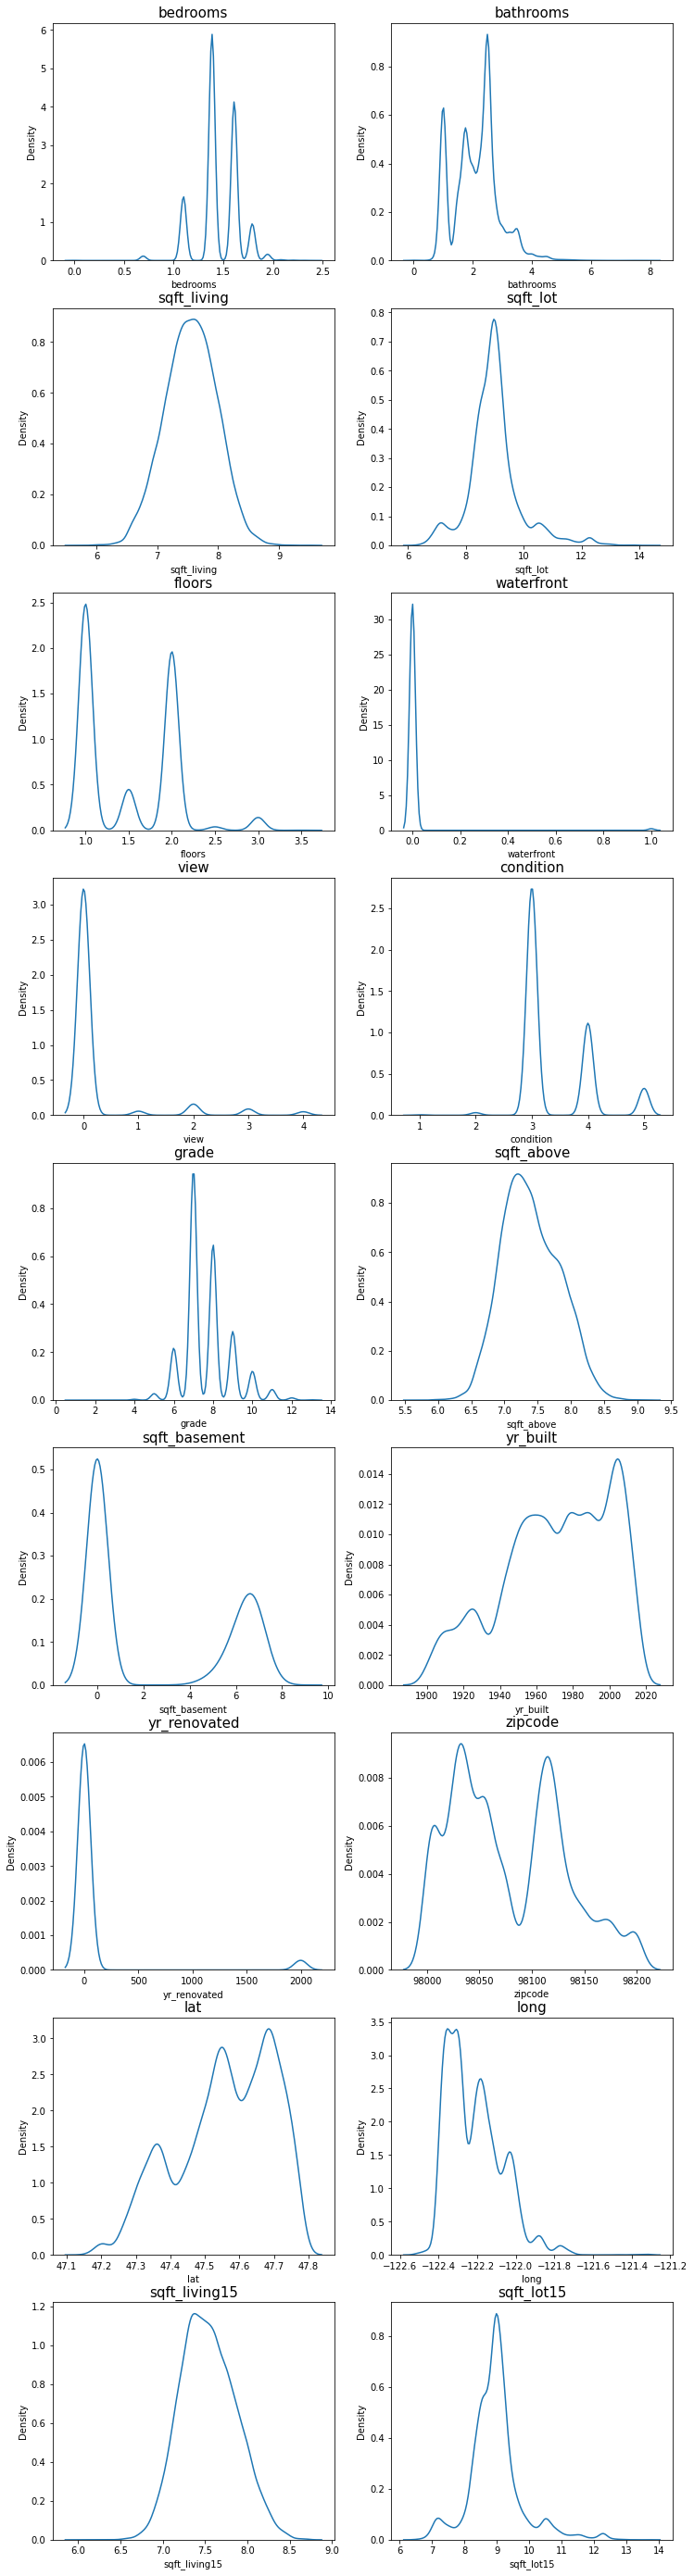

In [17]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

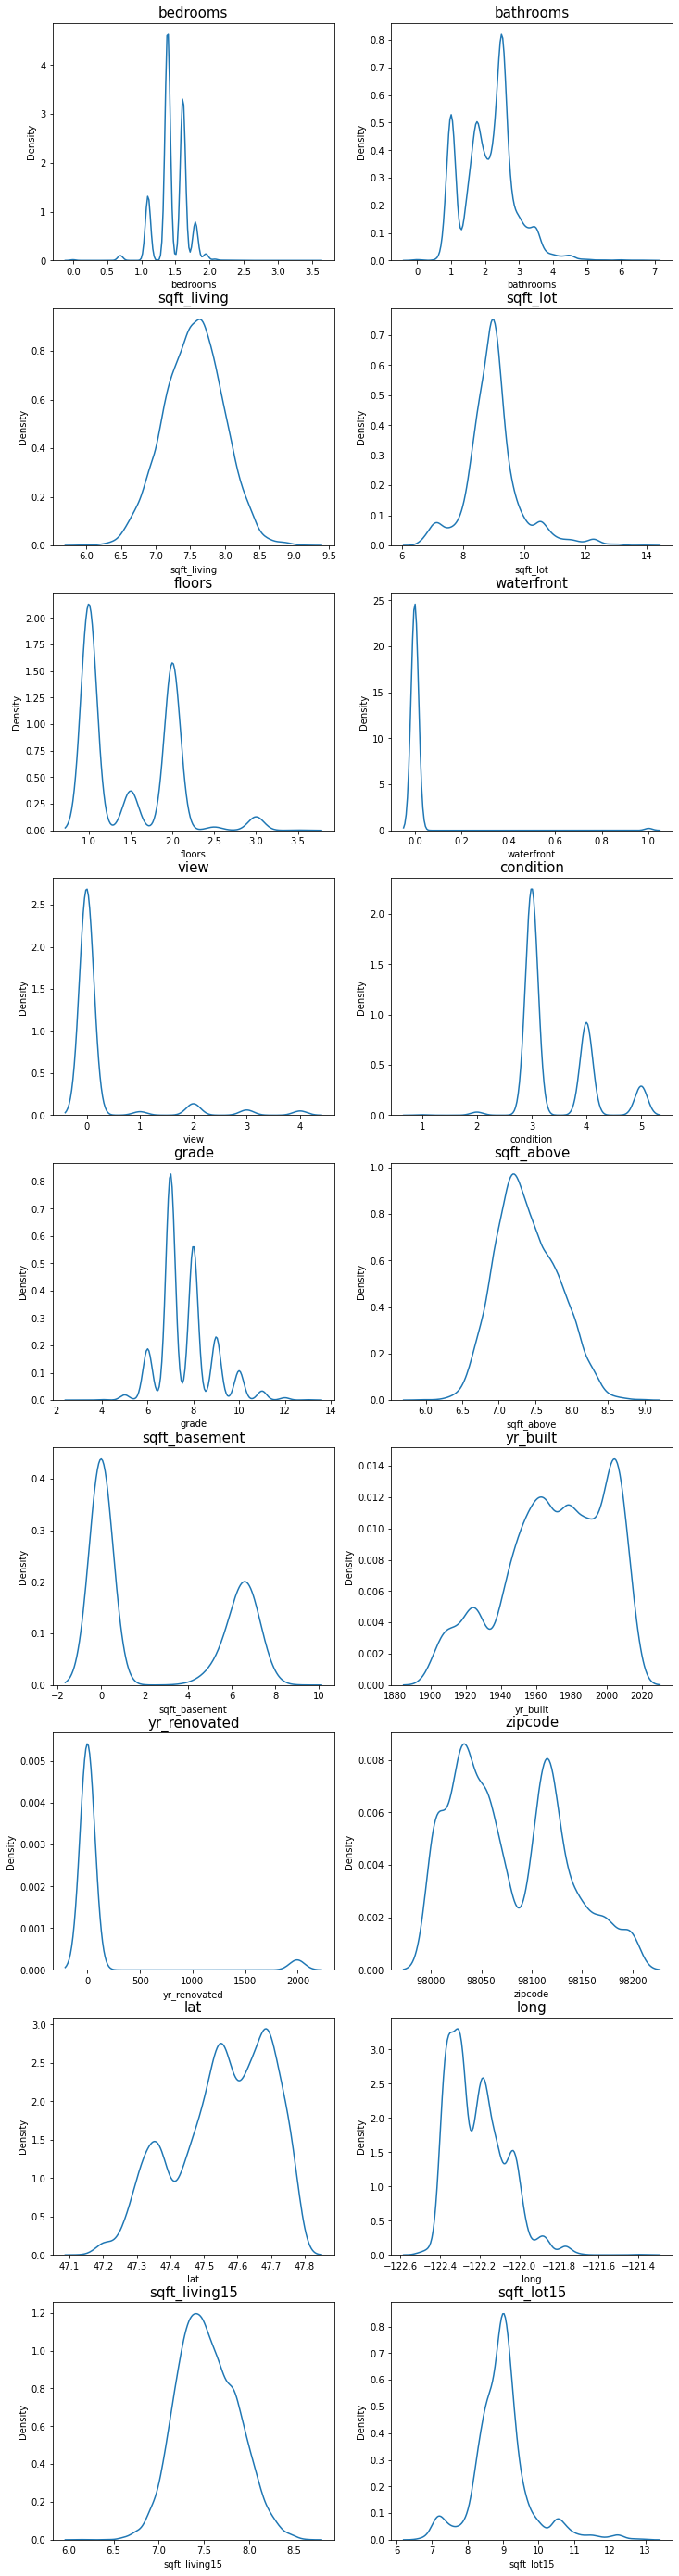

In [18]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = test.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=test[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

`train`과 `test`의 분포가 거의 identically distributed 임을 알 수 있다.

In [19]:
print(type(train))
print(type(test))
print(type(y))
print(train.shape)
print(test.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(15035, 19)
(6468, 19)
(15035,)


### 3.13.3. 모델 구성하기, `GridSearchCV`, 저장하기

- 핵심이 되는 것은 `my_GridSearch` 함수와 `save_submission` 함수이다.
실제 실험을 할 때에는 `my_GridSearch`를 반복적으로 돌리면서, 괜찮은 결과가 나오는지 계속적으로 관찰해야 한다.
그리고 괜찮은 결과가 나왔을 때, 그것을 저장하고 싶으면 `save_submission`을 실행하면 된다.
- 3.12. (4)을 기본적으로 따라가되, 조금 발전시켰다.
- 총 네 개의 셀로 구성했는데, 처음 두 개 셀은 위에 두 함수 `my_GridSearch`, `save_submission`를 정의하는 부분으로 고친 부분이 없다.
  - 세번째 셀은 `my_GridSearch`의 인자들을 설정하고, 시행하는 부분이다.
 함수 `my_GridSearch`에 넣을 인자들 중, 아직 정의하지 않은 `model`, `param_grid`을 설정할 수 있게 했고 `random_state`을 조정할 수 있도록 했다.
 함수의 반환값은 `results`라는 객체로 저장한 후 나타나도록 했다.
  - 네번째 셀은 `save_submission`을 시행하는 부분이다.
   3.12. (4)에서는 `model_name`과 `rmsle`를 각각 직접 입력해야 했었던 구조였지만, 이것을 자동화시켰다.
  `model_name`은 `model` 객체를 `str`으로 바꿔서 앞의 네 글자만 따온 것이다.
  각각의 `model`에 대하여 파일명에 반영되는 네 글자는 다음과 같다.
  
  |`model`                  |파일명|비고|
  |:-:                      |:-:|:-:|
  |LGBRegressor             |LGBR||
  |XGBRegressor             |XGBR||
  |RandomForestRegressor    |Rand||
  |GradientBoostingRegressor|Grad||
  
   `rmsle`도 즉각적으로 반영된다.
   이 값은, 가장 좋은 hyperparameter 조합에 대한 성능을 RMSLE(root mean squared logscale error)로 계산한 값이다.
   파일 저장 경로도 바꿔놓았다.
   이 '1st_trial' 파일과 같은 위치에 있는 폴더 `03`에 또다른 폴더 `results`를 두었는데 이 `results` 폴더에 결과파일들이 저장되도록 했다.   
  - LMS 노드에 있는 toy-tuning은
  $$(\text{max_depth},\text{n_estimators})\in\{1,10\}\times\{50,100\}$$
  와 같은 hyperparameter space를 고려했고, 그 결과로 0.164399 정도의 RMSLE 값을 얻었었다.
  최적의 hyperparameter pair는 $(\text{max_depth},\text{n_estimators})=(10,100)$이었다.
  이번 1st_trial에서는
  $$(\text{max_depth},\text{n_estimators})\in\{1, 5, 10, 20\}\times\{10, 50, 100, 150, 200\}$$
  의 hyperparameter space를 고려했고 0.161824의 RMSLE값을 얻었다.
  최적의 hyperparameter pair는 $(\text{max_depth},\text{n_estimators})=(10,200)$이었다.
  이를 통해, 두 `max_depth`와 `n_estimators`가 높을수록 성능이 좋아진다고 볼 수 있다.
  하지만 세부적인 결과를 보면 `max_depth`는 높아져도 크게 영향은 없다는 것도 확인할 수 있다.
- 이러한 tuning 작업을, 2nd_trial에서 이어서 할 것이다.

In [29]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [64]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '03/results/submission_{}_RMSLE_{}.csv'.format(model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [63]:
random_state = 2023
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
param_grid = {
    'max_depth': [1, 5, 10, 20],
    'n_estimators': [10, 50, 100, 150, 200],
}
results = my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5)
results

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,max_depth,n_estimators,score,RMSLE
14,10,200,-0.026187,0.161824
19,20,200,-0.026244,0.161999
13,10,150,-0.026456,0.162653
18,20,150,-0.026459,0.162662
12,10,100,-0.027024,0.164391
17,20,100,-0.027049,0.164467
9,5,200,-0.027159,0.164799
8,5,150,-0.027706,0.166451
7,5,100,-0.028795,0.169690
11,10,50,-0.029174,0.170804


In [65]:
model_name = str(model)[:4]
rmsle = '{:.4f}'.format(results.iloc[0][3])
save_submission(model, train, y, test, model_name, rmsle)

03/results/submission_LGBM_RMSLE_0.1618.csv saved!
